In [151]:
# import torch
# print(torch.cuda.is_available())
# print(torch.cuda.get_device_name(0))

In [152]:
import torch
import torch.nn as nn
import torch.optim as optim
from nltk.corpus import brown
from collections import Counter
import numpy as np
import random
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm

In [153]:
import nltk
nltk.download('brown')

[nltk_data] Downloading package brown to /home/mohak/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [154]:
sentences = brown.sents()[:]
corpus = [word.lower() for sentence in sentences for word in sentence]
vocab = set(corpus)
vocab_size = len(vocab)

In [155]:
word_to_index = {word: idx for idx, word in enumerate(vocab)}
index_to_word = {idx: word for word, idx in word_to_index.items()}

# CBOW Approach

In [156]:
def generate_cbow_data(corpus, window_size=2):
    data = []
    for idx, word in enumerate(corpus):
        if idx < window_size or idx >= len(corpus) - window_size:
            continue
        context = [word_to_index[corpus[i]] for i in range(idx - window_size, idx + window_size + 1) if i != idx]
        target = word_to_index[word]
        data.append((context, target))
    return data

In [157]:
class Word2VecCBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2VecCBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.output = nn.Linear(embedding_dim, vocab_size)

    def forward(self, context):
        embedded = self.embeddings(context).mean(dim=1)
        output = self.output(embedded)
        return output

In [158]:
def get_cbow_batches(training_data, batch_size):
    random.shuffle(training_data)
    for i in range(0, len(training_data), batch_size):
        batch = training_data[i:i + batch_size]
        contexts, targets = zip(*batch)
        yield torch.tensor(contexts, dtype=torch.long), torch.tensor(targets, dtype=torch.long)

# Skip Gram Approach

In [159]:
def generate_skipgram_data(corpus, window_size=2):
    data = []
    for idx, word in enumerate(corpus):
        if idx < window_size or idx >= len(corpus) - window_size:
            continue
        center_word = word_to_index[word]
        context_words = [word_to_index[corpus[i]] for i in range(idx - window_size, idx + window_size + 1) if i != idx]
        for context_word in context_words:
            data.append((center_word, context_word))
    return data

In [160]:
class Word2VecSkipGram(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2VecSkipGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.output = nn.Linear(embedding_dim, vocab_size)

    def forward(self, center):
        embedded = self.embeddings(center)
        output = self.output(embedded)
        return output

In [161]:
def get_skipgram_batches(training_data, batch_size):
    random.shuffle(training_data)
    for i in range(0, len(training_data), batch_size):
        batch = training_data[i:i + batch_size]
        centers, contexts = zip(*batch)
        yield torch.tensor(centers, dtype=torch.long), torch.tensor(contexts, dtype=torch.long)

# Hyperparameters

In [162]:
embedding_dim = 100
epochs = 10
batch_size = 256
window_size = 2
learning_rate=0.001

# Model Functions

In [163]:
# # Training function
# def train_model(model, training_data, batch_generator, device, epochs=10, batch_size=256, learning_rate=0.001):
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
#     for epoch in range(epochs):
#         total_loss = 0
#         for inputs, targets in batch_generator(training_data, batch_size):
#             inputs, targets = inputs.to(device), targets.to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()
#         print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")
    
#     return model

In [164]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def train_model(
    model, training_data, batch_generator, device, 
    epochs=10, batch_size=256, learning_rate=0.001, test_data=None
):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    epoch_metrics = {
        'loss': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'correlation': [],
    }

    # Training loop
    for epoch in range(epochs):
        total_loss = 0
        all_targets = []
        all_predictions = []

        for inputs, targets in batch_generator(training_data, batch_size):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_predictions.extend(preds)
            all_targets.extend(targets.cpu().numpy())
        
        # Calculating metrics for the epoch
        accuracy = accuracy_score(all_targets, all_predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_targets, all_predictions, average='macro',zero_division=0 
        )

        if test_data is not None:
            eval_results = evaluate_model(model, test_data, word_to_index)
            correlation = eval_results['correlation']
        else:
            correlation = 0 

        epoch_metrics['loss'].append(total_loss)
        epoch_metrics['accuracy'].append(accuracy)
        epoch_metrics['precision'].append(precision)
        epoch_metrics['recall'].append(recall)
        epoch_metrics['f1_score'].append(f1)
        epoch_metrics['correlation'].append(correlation)
        
        print(f"Epoch {epoch + 1}/{epochs} -> Loss: {total_loss:.4f}, "
              f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, "
              f"Recall: {recall:.4f}, F1: {f1:.4f}, Correlation: {correlation:.4f}")
    
    # Loss Plot
    plt.figure(figsize=(6, 4))
    for metric, values in epoch_metrics.items():
        if metric == 'loss':
            plt.plot(range(1, epochs + 1), values, label=metric)
    plt.xlabel("Epoch")
    plt.ylabel("Metrics")
    plt.title("Training Metrics Across Epochs")
    plt.legend()
    plt.grid()
    plt.show()  
    
    # Metrics Plot
    plt.figure(figsize=(6, 4))
    for metric, values in epoch_metrics.items():
        if metric != 'loss':
            plt.plot(range(1, epochs + 1), values, label=metric)
    plt.xlabel("Epoch")
    plt.ylabel("Metrics")
    # plt.ylim(0, 1) 
    plt.title("Training Metrics Across Epochs")
    plt.legend()
    plt.grid()
    plt.show()  

    return model


In [165]:
def get_similarity_score(word1, word2, word_embeddings, word_to_index):
    if word1 not in word_to_index or word2 not in word_to_index:
        return 0.0

    word1_index = word_to_index[word1]
    word2_index = word_to_index[word2]

    word1_vec = word_embeddings[word1_index]
    word2_vec = word_embeddings[word2_index]

    similarity = np.dot(word1_vec, word2_vec) / (np.linalg.norm(word1_vec) * np.linalg.norm(word2_vec))
    return similarity * 10

# Main

In [166]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda



Training CBOW model...
Epoch 1/10 -> Loss: 31816.3106, Accuracy: 0.1060, Precision: 0.0002, Recall: 0.0002, F1: 0.0001, Correlation: 0.0000
Epoch 2/10 -> Loss: 27829.1879, Accuracy: 0.1323, Precision: 0.0010, Recall: 0.0005, F1: 0.0005, Correlation: 0.0000
Epoch 3/10 -> Loss: 26444.7266, Accuracy: 0.1449, Precision: 0.0027, Recall: 0.0014, F1: 0.0013, Correlation: 0.0000
Epoch 4/10 -> Loss: 25449.4663, Accuracy: 0.1544, Precision: 0.0059, Recall: 0.0030, F1: 0.0031, Correlation: 0.0000
Epoch 5/10 -> Loss: 24653.4242, Accuracy: 0.1623, Precision: 0.0108, Recall: 0.0058, F1: 0.0062, Correlation: 0.0000
Epoch 6/10 -> Loss: 23982.1182, Accuracy: 0.1693, Precision: 0.0172, Recall: 0.0099, F1: 0.0106, Correlation: 0.0000
Epoch 7/10 -> Loss: 23397.0779, Accuracy: 0.1757, Precision: 0.0275, Recall: 0.0165, F1: 0.0179, Correlation: 0.0000
Epoch 8/10 -> Loss: 22875.9931, Accuracy: 0.1817, Precision: 0.0417, Recall: 0.0266, F1: 0.0284, Correlation: 0.0000
Epoch 9/10 -> Loss: 22405.6564, Accuracy

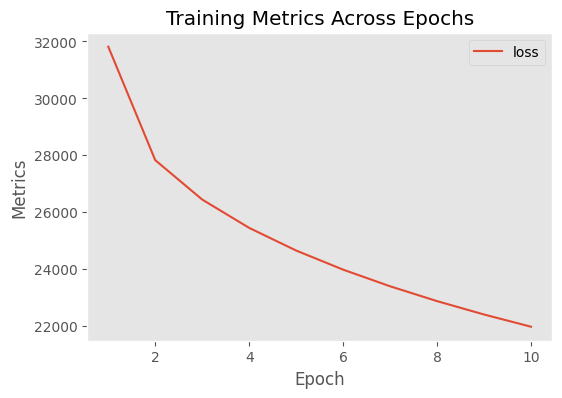

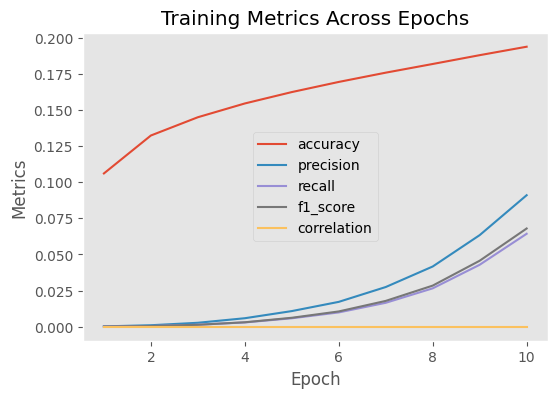

<Figure size 640x480 with 0 Axes>

In [167]:
# Generate training data & Train CBOW model
cbow_training_data = generate_cbow_data(corpus, window_size)

print("\nTraining CBOW model...")
cbow_model = Word2VecCBOW(vocab_size, embedding_dim).to(device)
cbow_model = train_model(cbow_model, cbow_training_data, get_cbow_batches, device,epochs, batch_size, learning_rate)



Training Skip-gram model...
Epoch 1/10 -> Loss: 130057.1079, Accuracy: 0.0727, Precision: 0.0002, Recall: 0.0002, F1: 0.0001, Correlation: 0.0000
Epoch 2/10 -> Loss: 123071.2372, Accuracy: 0.0813, Precision: 0.0008, Recall: 0.0003, F1: 0.0004, Correlation: 0.0000
Epoch 3/10 -> Loss: 121479.7877, Accuracy: 0.0842, Precision: 0.0013, Recall: 0.0004, F1: 0.0006, Correlation: 0.0000
Epoch 4/10 -> Loss: 120404.7408, Accuracy: 0.0859, Precision: 0.0018, Recall: 0.0005, F1: 0.0007, Correlation: 0.0000
Epoch 5/10 -> Loss: 119566.7544, Accuracy: 0.0871, Precision: 0.0021, Recall: 0.0006, F1: 0.0008, Correlation: 0.0000
Epoch 6/10 -> Loss: 118883.1592, Accuracy: 0.0882, Precision: 0.0024, Recall: 0.0007, F1: 0.0009, Correlation: 0.0000
Epoch 7/10 -> Loss: 118292.0934, Accuracy: 0.0890, Precision: 0.0027, Recall: 0.0007, F1: 0.0010, Correlation: 0.0000
Epoch 8/10 -> Loss: 117774.0767, Accuracy: 0.0898, Precision: 0.0029, Recall: 0.0008, F1: 0.0010, Correlation: 0.0000
Epoch 9/10 -> Loss: 117301.

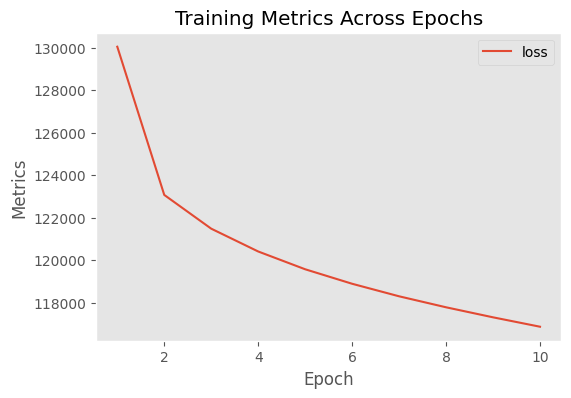

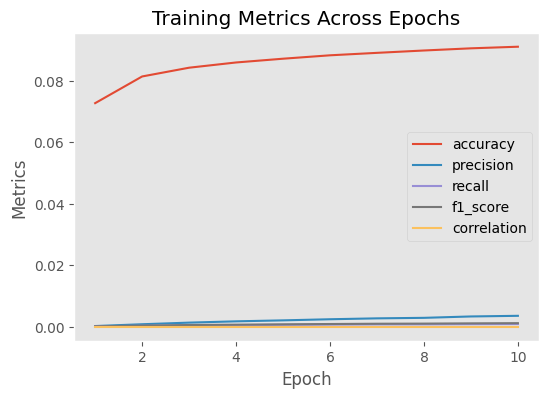

<Figure size 640x480 with 0 Axes>

In [168]:
# Generate training data & Train Skip-gram model
skipgram_training_data = generate_skipgram_data(corpus, window_size)

print("\nTraining Skip-gram model...")
skipgram_model = Word2VecSkipGram(vocab_size, embedding_dim).to(device)
skipgram_model = train_model(skipgram_model, skipgram_training_data, get_skipgram_batches, device,epochs, batch_size, learning_rate)

# Evaluation

In [169]:
# Evaluation function
# def evaluate_model(model, test_file_path, word_to_index):
#     def load_txt_dataset(file_path):
#         columns = ['word1', 'word2', 'POS', 'SimLex999', 'conc(w1)', 'conc(w2)',
#                   'concQ', 'Assoc(USF)', 'SimAssoc333', 'SD(SimLex)']
#         return pd.read_csv(file_path, delimiter="\t", names=columns, skiprows=1)

#     test_data = load_txt_dataset(test_file_path)
#     word_pairs = test_data[['word1', 'word2']]
#     human_scores = test_data['SimLex999']
    
#     word_embeddings = model.embeddings.weight.detach().cpu().numpy()
#     predicted_scores = []
    
#     for _, row in word_pairs.iterrows():
#         similarity = get_similarity_score(row['word1'], row['word2'], word_embeddings, word_to_index)
#         predicted_scores.append(similarity)

#     valid_indices = [i for i, score in enumerate(predicted_scores) if score is not None]
#     human_scores = human_scores.iloc[valid_indices]
#     predicted_scores = np.array([predicted_scores[i] for i in valid_indices])
#     # print(predicted_scores)
#     # print(human_scores)
#     pearson_corr, _ = pearsonr(human_scores, predicted_scores)
#     spearman_corr, _ = spearmanr(human_scores, predicted_scores)

#     return {
#         "Pearson Correlation": pearson_corr,
#         "Spearman Correlation": spearman_corr
#     }


    

In [170]:
def evaluate_model(model, test_file_path, word_to_index, similarity_threshold=0.5):
    def load_txt_dataset(file_path):
        columns = ['word1', 'word2', 'POS', 'SimLex999', 'conc(w1)', 'conc(w2)',
                  'concQ', 'Assoc(USF)', 'SimAssoc333', 'SD(SimLex)']
        return pd.read_csv(file_path, delimiter="\t", names=columns, skiprows=1)

    test_data = load_txt_dataset(test_file_path)
    word_pairs = test_data[['word1', 'word2']]
    human_scores = test_data['SimLex999']
    
    word_embeddings = model.embeddings.weight.detach().cpu().numpy()
    predicted_scores = []
    
    for _, row in tqdm(word_pairs.iterrows(),"Evaluating",total=len(word_pairs)):
        similarity = get_similarity_score(row['word1'], row['word2'], word_embeddings, word_to_index)
        predicted_scores.append(similarity)

    valid_indices = [i for i, score in enumerate(predicted_scores) if score is not None]
    human_scores = human_scores.iloc[valid_indices]
    predicted_scores = np.array([predicted_scores[i] for i in valid_indices])
    
    # Normalize scores to 0-1 range
    human_scores_norm = (human_scores - human_scores.min()) / (human_scores.max() - human_scores.min())
    predicted_scores_norm = (predicted_scores - predicted_scores.min()) / (predicted_scores.max() - predicted_scores.min())


    pearson_corr, _ = pearsonr(human_scores, predicted_scores)
    spearman_corr, _ = spearmanr(human_scores, predicted_scores)
    correlation = (pearson_corr + spearman_corr) / 2    
    
    # Convert to binary predictions
    human_binary = (human_scores_norm >= similarity_threshold).astype(int)
    predicted_binary = (predicted_scores_norm >= similarity_threshold).astype(int)
    # human_binary = human_scores_norm
    # predicted_binary = predicted_scores_norm

    
    # Calculate metrics
    accuracy = accuracy_score(human_binary, predicted_binary)
    precision, recall, f1, _ = precision_recall_fscore_support(human_binary, predicted_binary, average='binary')
    return {
        'accuracy': round(accuracy, 4),
        'precision': round(precision, 4),
        'f1_score': round(f1, 4),
        'recall': round(recall, 4),
        'correlation': round(correlation, 4)
    }

In [171]:
# Evaluate both models
test_dataset_path = "./datasets/SimLex-999.txt"

print("\nEvaluating CBOW model...")
cbow_results = evaluate_model(cbow_model, test_dataset_path, word_to_index)
print(f"CBOW Metrics:")
for metric, value in cbow_results.items():
    print(f"{metric}: {value:.4f}")

print("\nEvaluating Skip-gram model...")
skipgram_results = evaluate_model(skipgram_model, test_dataset_path, word_to_index)
print(f"Skip-gram Metrics:")
for metric, value in skipgram_results.items():
    print(f"{metric}: {value:.4f}")


Evaluating CBOW model...


Evaluating: 100%|██████████| 999/999 [00:00<00:00, 26324.91it/s]


CBOW Metrics:
accuracy: 0.5085
precision: 0.4498
f1_score: 0.4771
recall: 0.5079
correlation: 0.0239

Evaluating Skip-gram model...


Evaluating: 100%|██████████| 999/999 [00:00<00:00, 31411.06it/s]

Skip-gram Metrics:
accuracy: 0.5085
precision: 0.4384
f1_score: 0.4203
recall: 0.4036
correlation: 0.0200
